In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions

In [2]:
@tf.function
def interpolate_images(baseline, image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    delta = image - baseline
    images = baseline + alphas_x * delta
    return images

In [3]:
@tf.function
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        probs = model(images)
        probs = probs[:, target_class_idx]
    return tape.gradient(probs, images)


In [4]:
def integrated_gradients(image, target_class_idx, baseline=None, steps=50):
    if baseline is None:
        baseline = tf.zeros(shape=image.shape)
    alphas = tf.linspace(start=0.0, stop=1.0, num=steps+1)
    interpolated_images = interpolate_images(baseline, image, alphas)

    grads = []
    for img in interpolated_images:
        grad = compute_gradients(tf.expand_dims(img, axis=0), target_class_idx)
        grads.append(grad[0])
    grads = tf.stack(grads, axis=0)

    avg_grads = tf.reduce_mean(grads[:-1], axis=0)
    delta = image[0] - baseline[0]
    integrated_grads = delta * avg_grads
    return integrated_grads

In [5]:
@tf.function
def create_adversarial_pattern(model, input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
232528/232528 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


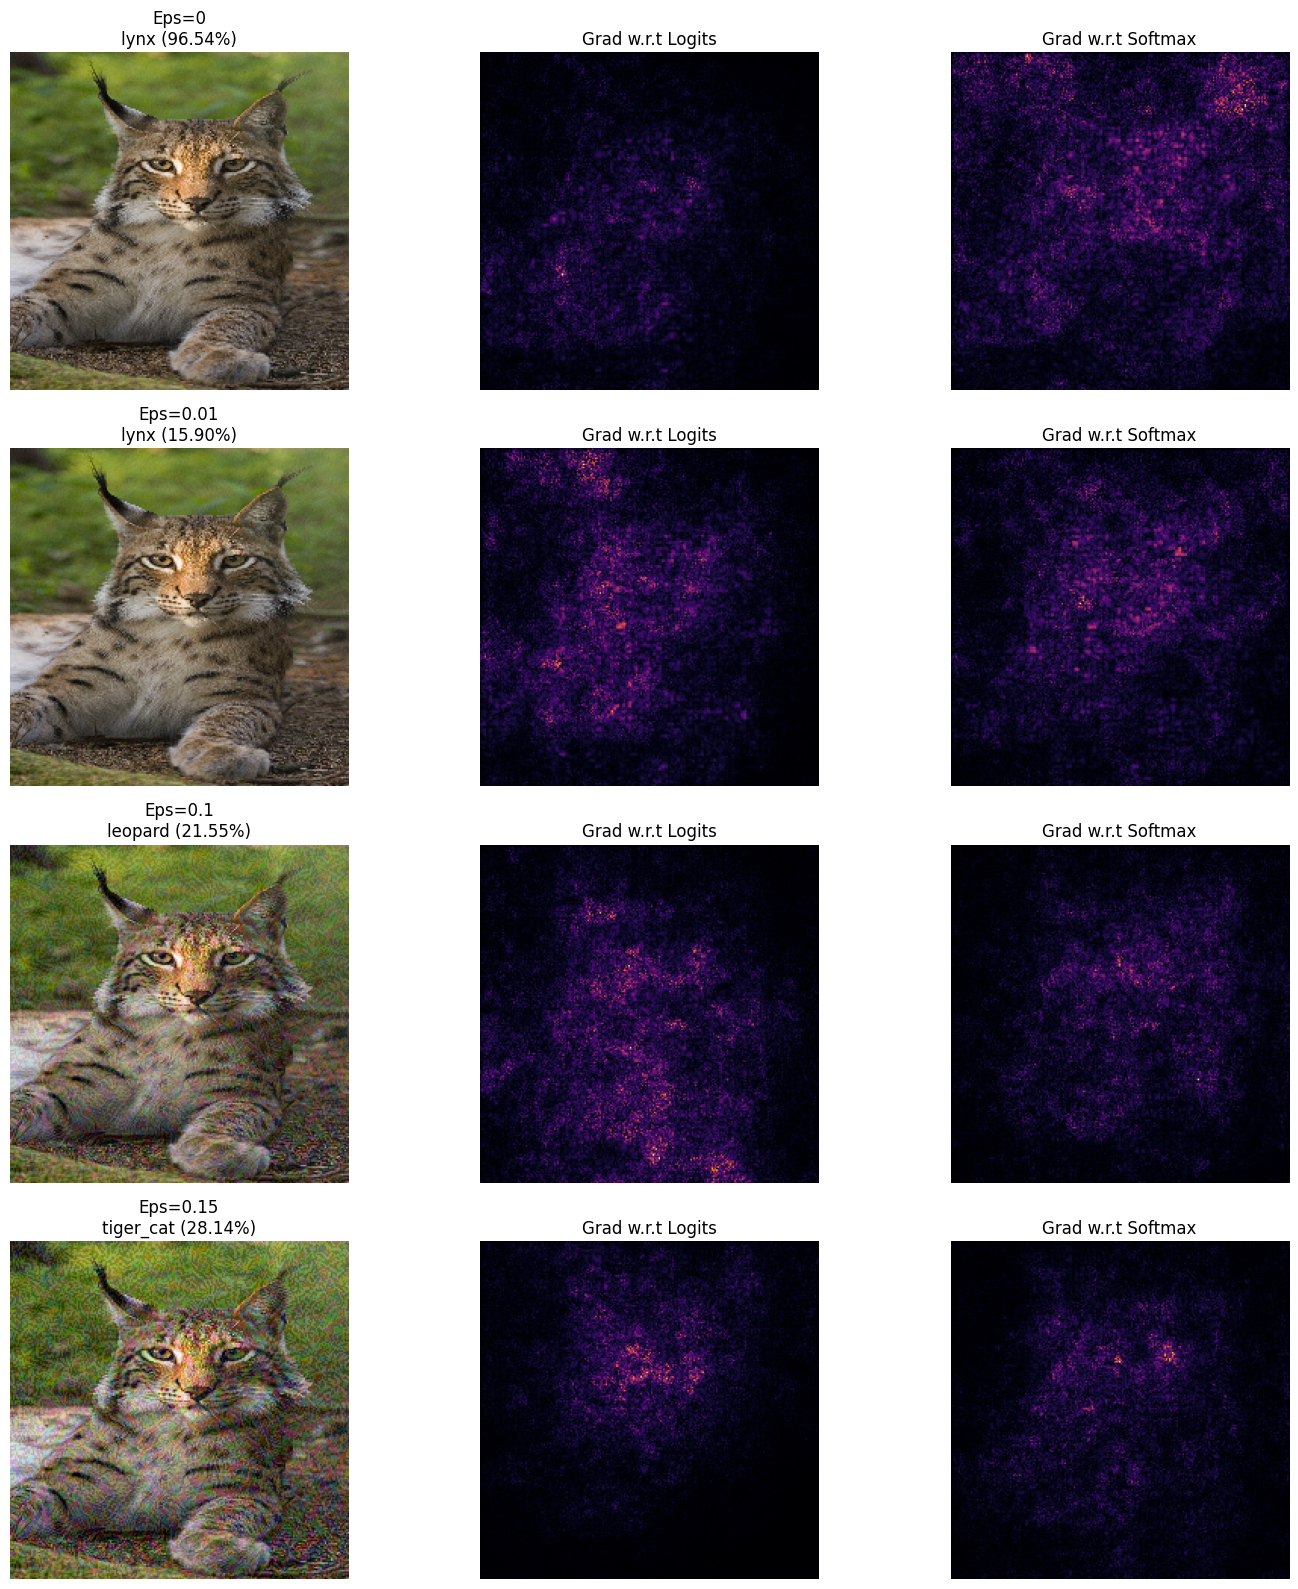

In [6]:


model = mobilenet_v2.MobileNetV2(weights="imagenet")
model.trainable = False

img_path = tf.keras.utils.get_file('Lynx_ImageNet.jpg',
'https://upload.wikimedia.org/wikipedia/commons/6/68/Lynx_lynx_poing.jpg')

img_raw = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img_raw)
img_batch = np.expand_dims(img, axis=0)
img_batch = preprocess_input(img_batch)
img_batch = tf.convert_to_tensor(img_batch, dtype=tf.float32)
loss_object = tf.keras.losses.CategoricalCrossentropy()



model_logits = tf.keras.Model(inputs=model.input, outputs=model.layers[-1].input)

epsilons = [0, 0.01, 0.1, 0.15]
pred = model.predict(img_batch)
label_idx = np.argmax(pred[0])
label_onehot = tf.one_hot(label_idx, pred.shape[-1])

plt.figure(figsize=(15, len(epsilons)*4))

for i, eps in enumerate(epsilons):
    adv_x = img_batch + eps * create_adversarial_pattern(model, img_batch, tf.expand_dims(label_onehot, axis=0))
    adv_x = tf.clip_by_value(adv_x, -1, 1)

    adv_pred = model.predict(adv_x)
    decoded = decode_predictions(adv_pred, top=1)[0][0]
    confidence = decoded[2]*100

    # Integrated Gradients (your original)
    ig_attributions = integrated_gradients(adv_x, np.argmax(adv_pred[0]), steps=64)
    ig_attributions = tf.reduce_sum(tf.math.abs(ig_attributions), axis=-1)

    # Heatmap before softmax (logits)
    with tf.GradientTape() as tape:
        tape.watch(adv_x)
        logits = model_logits(adv_x)
        loss_logits = logits[:, np.argmax(adv_pred[0])]
    grad_logits = tape.gradient(loss_logits, adv_x)
    heatmap_logits = tf.reduce_sum(tf.math.abs(grad_logits), axis=-1)[0]

    # Heatmap after softmax
    with tf.GradientTape() as tape:
        tape.watch(adv_x)
        probs = model(adv_x)
        loss_probs = probs[:, np.argmax(adv_pred[0])]
    grad_probs = tape.gradient(loss_probs, adv_x)
    heatmap_probs = tf.reduce_sum(tf.math.abs(grad_probs), axis=-1)[0]

    heatmap_logits = heatmap_logits / (tf.reduce_max(heatmap_logits) + 1e-8)


    plt.subplot(len(epsilons), 3, 3*i+1)
    plt.imshow((adv_x[0]+1)/2)
    plt.title(f"Eps={eps}\n{decoded[1]} ({confidence:.2f}%)")
    plt.axis("off")

    plt.subplot(len(epsilons), 3, 3*i+2)
    plt.imshow(heatmap_logits, cmap="inferno")
    plt.title("Grad w.r.t Logits")
    plt.axis("off")

    plt.subplot(len(epsilons), 3, 3*i+3)
    plt.imshow(heatmap_probs, cmap="inferno")
    plt.title("Grad w.r.t Softmax")
    plt.axis("off")

plt.tight_layout()
plt.show()
